In [190]:
import h5py
import copy
import lmfit
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from rich.progress import Progress
from scipy.stats import binned_statistic
from utils.plot_utils import set_fontsize
from utils.hdf_utils import load_measurement_data_devices_attrs

In [191]:
def ratio_with_error(a,b,σa,σb):
    ratio = a/b
    err = ratio * np.sqrt((σa/a)**2 + (σb/b)**2)
    return ratio, err

In [192]:
hdf_dir = Path("../data")

In [193]:
yag_channel = 0
pmt_channel = 1
pd_channel = 2
pdn_channel = 3
shutter_channel = 4
pdrc_channel = 5

In [333]:
fname = "2021_3_16.hdf"

with h5py.File(hdf_dir / fname, 'r') as f:
    dset_names = list(f.keys())
    for idn, name in enumerate(f.keys()):
        print(f"{idn:<2} <> {name:<60} : {len(f[name]['readout']['PXIe-5171'])}")

0  <> 1615922769 scan R0 F1 (J12 and J23 microwaves and P2 F1 RC)  : 321
1  <> 1615923107 scan P2 F1 (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 321
2  <> 1615923360 scan P2 F1 (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 641
3  <> 1615923807 scan P2 F1 (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 1601
4  <> 1615924487 scan P2 F1 no laser pol switch (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 1281
5  <> 1615925203 scan polarizatn switching frequencies (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 4201
6  <> 1615926264 scan polarizatn switching frequencies (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 1
7  <> 1615926314 RC pol 15 MHz (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 1281
8  <> 1615926937 R0 F1 data for gain calculation (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 501
9  <> 1615927089 R0 F1 data for gain calculation (J12 and J23 microwaves and P2 F1 RC and R0 F1 DET) : 1092
10 <> 1615928084 find R0 F1    

## R0 F1 ratio and population
Accidentally had RC on P2 F2 instead of P2 F1

In [559]:
dset_name = dset_names[9]
devices = ()

In [560]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [561]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [562]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 5
fl_cutoff = -5000

In [563]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [565]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [566]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 8.19 +/- 0.15


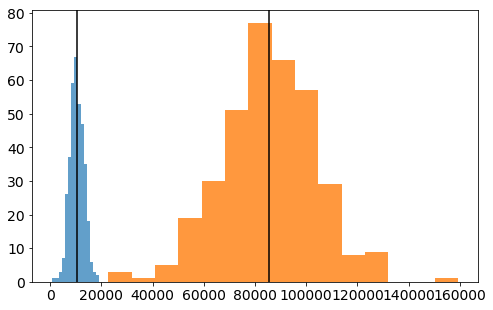

In [567]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15)
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15)
ax.axvline(o, color = 'k')

set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 8.49 +/- 0.13


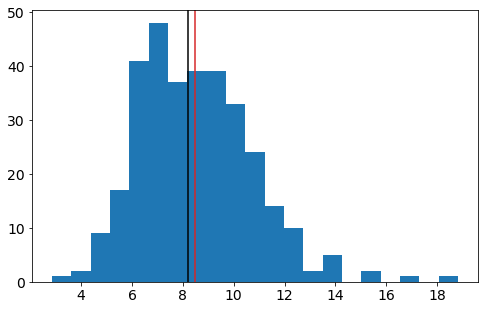

In [568]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F2 ratio and population
Accidentally had RC on P2 F2 instead of P2 F1

In [538]:
dset_name = dset_names[12]
devices = ()

In [539]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [540]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [541]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 5
fl_cutoff = -5000

In [542]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [543]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [544]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 10.06 +/- 0.17


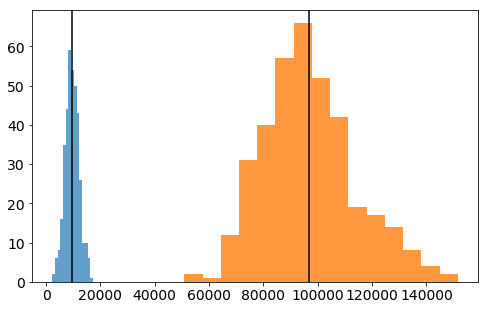

In [547]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15)
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15)
ax.axvline(o, color = 'k')

set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 10.24 +/- 0.14


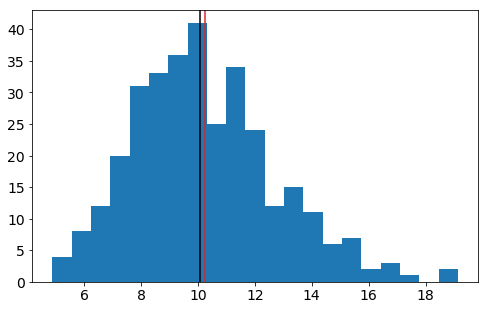

In [548]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## Check effect polarization switching frequency (Laser RC P2 F1 only)

In [764]:
dset_name = dset_names[16]
devices = ()

In [765]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [766]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [768]:
scan_parameter = 'BK4063 SetChannel1Frequency'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [774]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000
shutter_cutoff = 10000

In [770]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [775]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

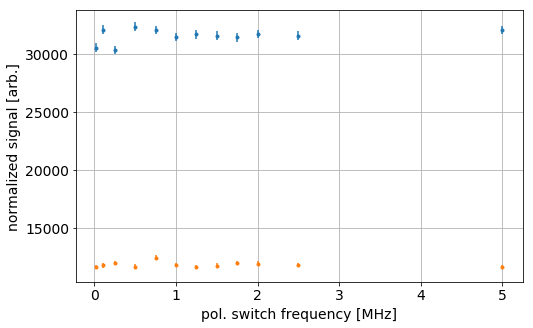

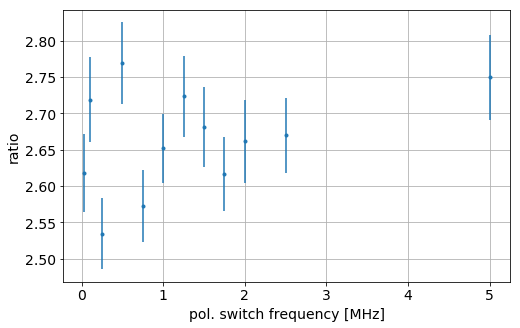

In [779]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means/1e6, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means/1e6, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('pol. switch frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means/1e6, ratio, yerr = err, fmt = '.')

ax.set_xlabel('pol. switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

## R0 F1 ratio and population without pol switching RC
Now with RC on P2 F1

In [529]:
dset_name = dset_names[17]
devices = ()

In [530]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [531]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [532]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 5
fl_cutoff = -5000

In [533]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [534]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [535]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 2.28 +/- 0.04


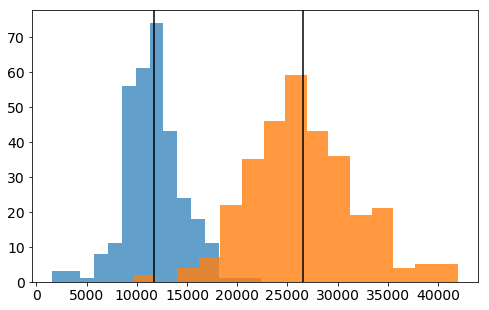

In [536]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15)
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15)
ax.axvline(o, color = 'k')

set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 2.39 +/- 0.05


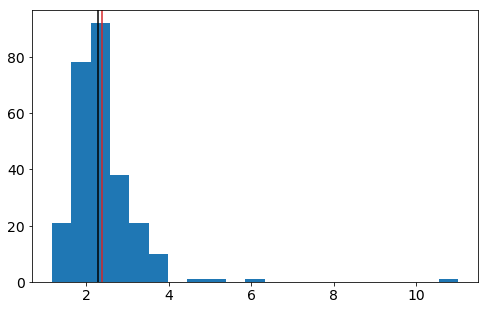

In [537]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F1 ratio and population with pol switching RC

In [569]:
dset_name = dset_names[18]
devices = ()

In [570]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [571]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [572]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 5
fl_cutoff = -5000

In [573]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

C:\Users\CeNTREX\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in subtract
  


In [574]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [575]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 2.69 +/- 0.05


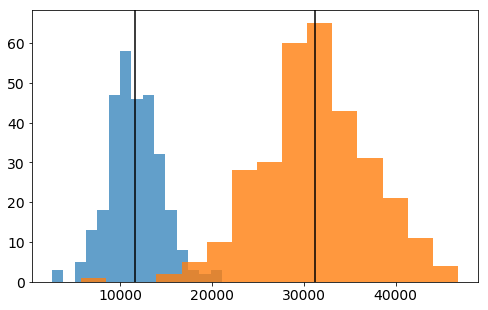

In [576]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15)
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15)
ax.axvline(o, color = 'k')

set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 2.86 +/- 0.06


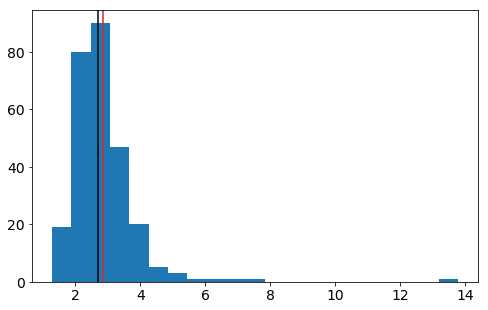

In [577]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## Check effect J12 microwave power

In [792]:
dset_name = dset_names[21]
devices = ()

In [793]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [794]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [797]:
scan_parameter = 'SynthHD Pro SetPowerCHAGUI'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [798]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000
shutter_cutoff = 10000

In [799]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [800]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

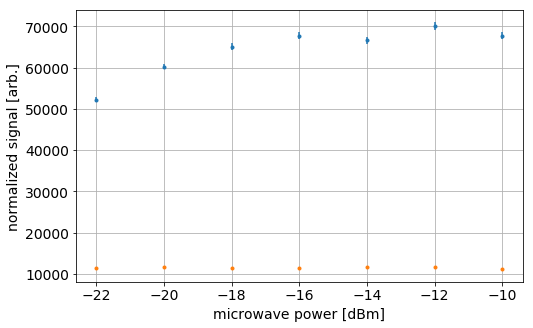

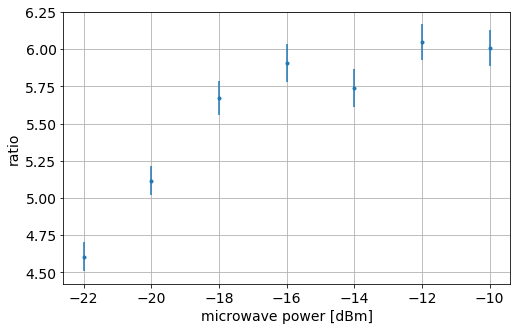

In [802]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

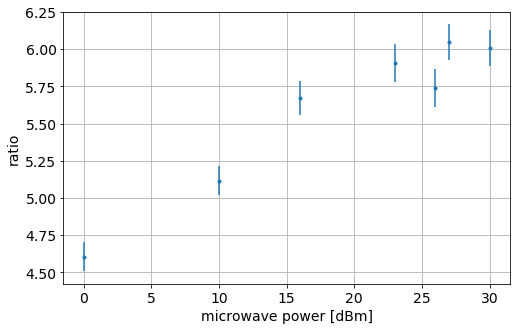

In [804]:
# power conversion
conv_26 = {-22: 0, -20:10, -18: 16, -16: 23, -14: 26, -12: 27, -10: 30}
conv_40 = {-15.26: 0, -13.9: 5, -11.71: 10, -10.57: 15, -9.82: 20, -9.55: 22, -9.35: 24, -8.8: 28}
x = np.array([conv_26[bm] for bm in bin_means])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

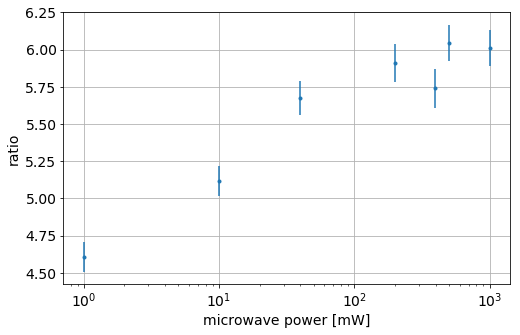

In [810]:
# power conversion
conv_26 = {-22: 0, -20:10, -18: 16, -16: 23, -14: 26, -12: 27, -10: 30}
conv_40 = {-15.26: 0, -13.9: 5, -11.71: 10, -10.57: 15, -9.82: 20, -9.55: 22, -9.35: 24, -8.8: 28}
x = np.array([conv_26[bm] for bm in bin_means])
x = 10**(x/10)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [mW]')
ax.set_ylabel('ratio')

ax.grid(True)
ax.set_xscale('log')
set_fontsize(ax, 14)

## Check effect J23 microwave power

In [811]:
dset_name = dset_names[23]
devices = ()

In [812]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [813]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [816]:
scan_parameter = 'SynthHD Pro SetPowerCHBGUI'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [817]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000
shutter_cutoff = 10000

In [818]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [819]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

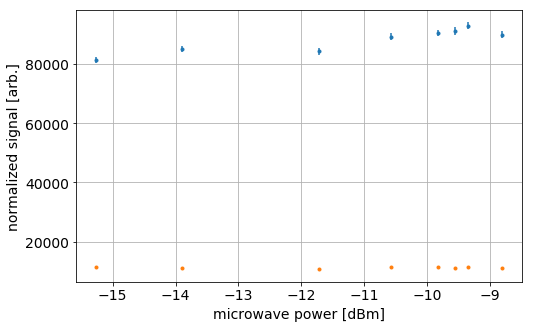

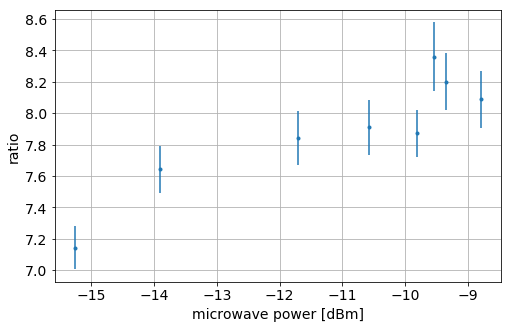

In [820]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

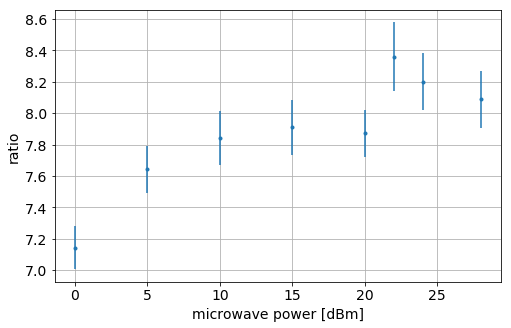

In [821]:
# power conversion
conv_26 = {-22: 0, -20:10, -18: 16, -16: 23, -14: 26, -12: 27, -10: 30}
conv_40 = {-15.26: 0, -13.9: 5, -11.71: 10, -10.57: 15, -9.82: 20, -9.55: 22, -9.35: 24, -8.8: 28}
x = np.array([conv_40[bm] for bm in bin_means])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [dBm]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

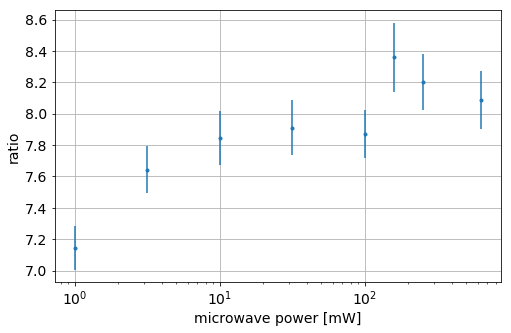

In [822]:
# power conversion
conv_26 = {-22: 0, -20:10, -18: 16, -16: 23, -14: 26, -12: 27, -10: 30}
conv_40 = {-15.26: 0, -13.9: 5, -11.71: 10, -10.57: 15, -9.82: 20, -9.55: 22, -9.35: 24, -8.8: 28}
x = np.array([conv_40[bm] for bm in bin_means])
x = 10**(x/10)

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(x, ratio, yerr = err, fmt = '.')

ax.set_xlabel('microwave power [mW]')
ax.set_ylabel('ratio')

ax.grid(True)
ax.set_xscale('log')
set_fontsize(ax, 14)

## Check effect polarization switching frequency (Laser RC P2 F1 and J12 J23 microwaves)

In [780]:
dset_name = dset_names[24]
devices = ()

In [781]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [782]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [783]:
scan_parameter = 'BK4063 SetChannel1Frequency'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [784]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000
shutter_cutoff = 10000

In [785]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [786]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > shutter_cutoff
mask_sh_closed = ~mask_sh_open

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat = []
    err = []
    for f in np.unique(scan_parameters):
        mask_frequency = scan_parameters == f
        mt = m & mask_frequency
        dat = (fluorescence_integral/absorption_integral)[mt]
        stat.append(np.nanmean(dat))
        err.append(np.nanstd(dat)/np.sqrt(len(dat)-1))
    stat = np.array(stat)
    err = np.array(err)
    results.append((stat, err))
    
bin_means = np.unique(scan_parameters)

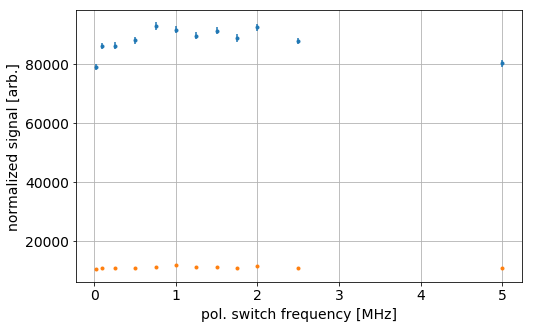

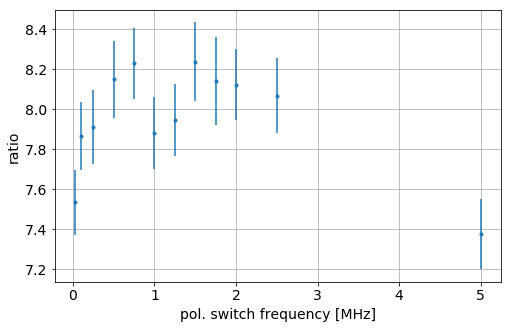

In [787]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means/1e6, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means/1e6, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('pol. switch frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')

ax.grid(True)

set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means/1e6, ratio, yerr = err, fmt = '.')

ax.set_xlabel('pol. switch frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)
set_fontsize(ax, 14)

## R0 F1 ratio and population without RC laser pol switching
With J12 and J23 microwaves

In [621]:
dset_name = dset_names[25]
devices = ()

In [622]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [623]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [624]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [625]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [626]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [627]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 7.82 +/- 0.16


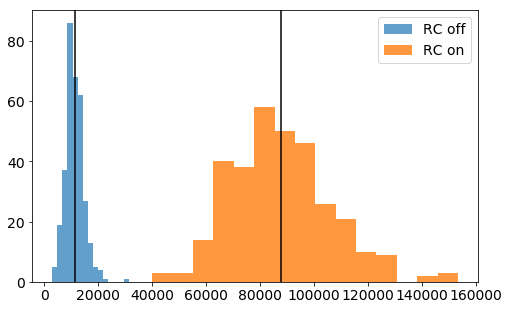

In [628]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 8.48 +/- 0.16


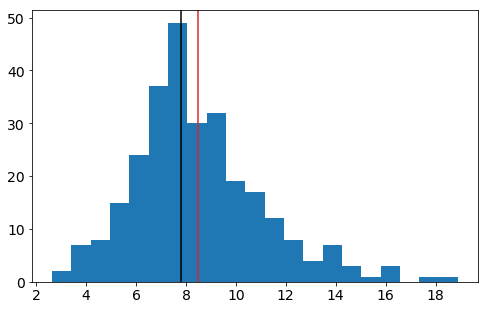

In [629]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F1 ratio and population with RC laser pol switching
With J12 and J23 microwaves

In [613]:
dset_name = dset_names[26]
devices = ()

In [614]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [615]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [616]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [617]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [618]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [619]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 8.12 +/- 0.16


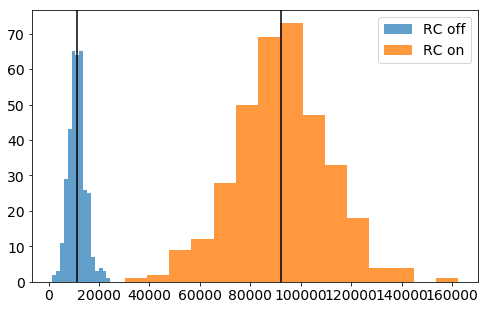

In [620]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")


ratio is 8.72 +/- 0.16


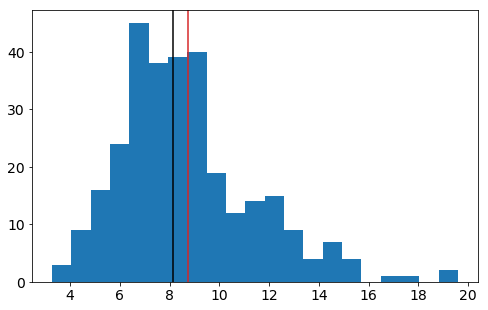

In [595]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F2 ratio and population with RC laser pol switching
With J12 and J23 microwaves

In [630]:
dset_name = dset_names[28]
devices = ()

In [631]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [632]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [633]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [634]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [635]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [636]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 3.48 +/- 0.07


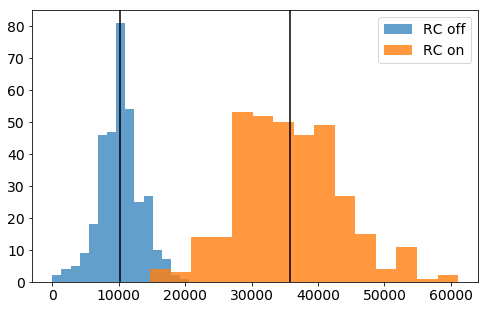

In [637]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 3.95 +/- 0.10


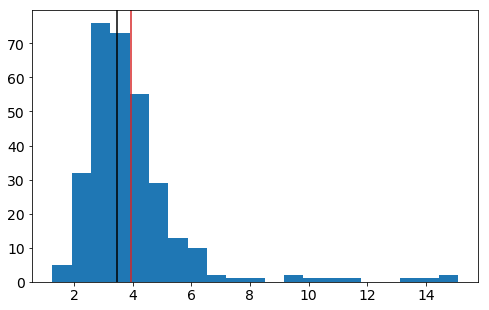

In [638]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## Q1 F1 ratio and population with RC laser pol switching

In [639]:
dset_name = dset_names[33]
devices = ()

In [640]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [641]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [642]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [643]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [644]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [645]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 0.14 +/- 0.00


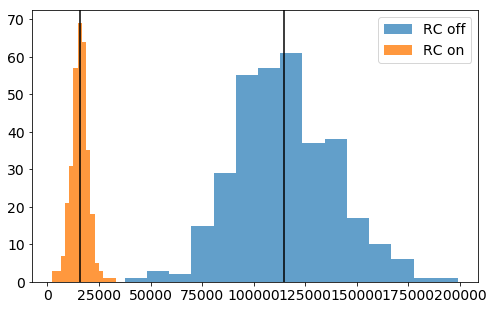

In [649]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 0.14 +/- 0.002


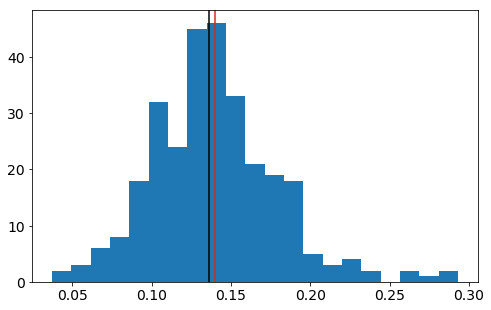

In [650]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.3f}")

In [648]:
np.nanmean(dat[mask_sh_open])

15639.149759975282

## Q1 F1 ratio and population no microwaves or RC laser

In [651]:
dset_name = dset_names[34]
devices = ()

In [652]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [653]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [654]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [655]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [656]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

In [657]:
dat = (fluorescence_integral/absorption_integral)

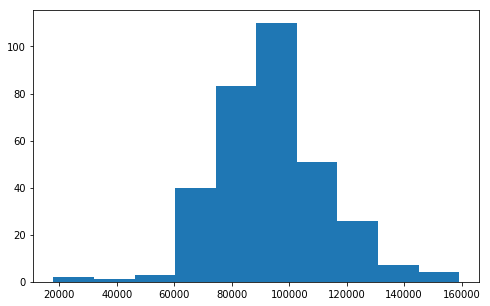

In [217]:
fig, ax = plt.subplots(figsize = (8,5))
ax.hist(dat[~np.isnan(dat)]);

## Check depletion in J2 with P2 F1 (no microwaves)

In [744]:
dset_name = dset_names[38]
devices = ()

In [745]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [746]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [747]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [748]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [749]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [750]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

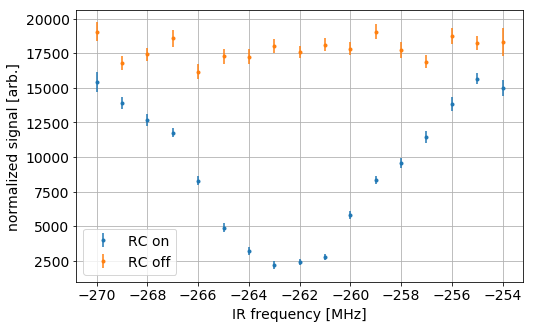

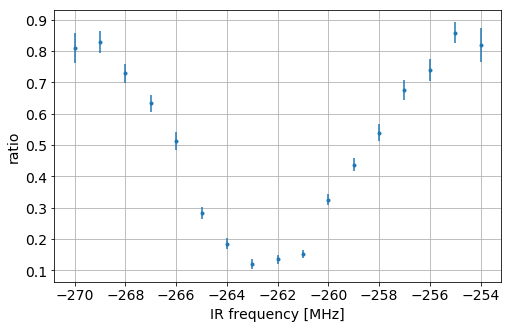

In [751]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Check depletion in J2 with P2 F1 (with microwaves)

In [730]:
dset_name = dset_names[39]
devices = ()

In [731]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [732]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [733]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [734]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [735]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [736]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

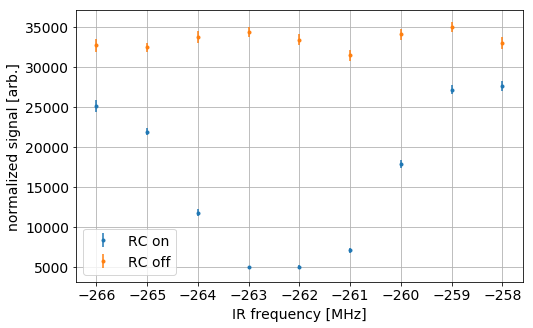

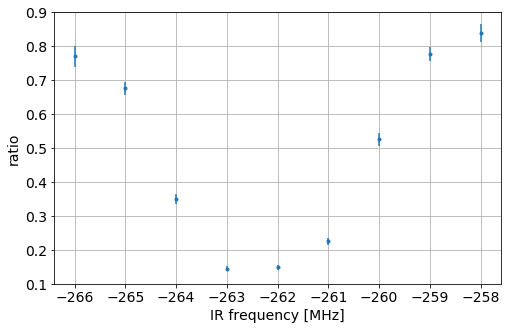

In [737]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## Check depletion in J3 with R3 F4 (with microwaves)

In [754]:
dset_name = dset_names[44]
devices = ()

In [755]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [756]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [757]:
scan_parameter = 'Laser Lock 1 SetLockPointSeed1'
scan_parameters = np.array([float(pxie_attrs[idx][scan_parameter]) for idx in range(1,len(pxie)+1)])

In [758]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [759]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [760]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000
mask_sh_closed = ~mask_sh_open

bin_width = np.diff(np.unique(scan_parameters)).min()
bins = np.arange(np.unique(scan_parameters).min()-bin_width/2, np.unique(scan_parameters).max()+bin_width, bin_width)

results = []
for m in [mask_sh_open, mask_sh_closed]:
    stat, bin_edges, bin_number = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanmean(x), bins = bins)
    err, _, _ = binned_statistic(scan_parameters[m], (fluorescence_integral/absorption_integral)[m], lambda x: np.nanstd(x)/np.sqrt(len(x)-1), bins = bins)
    results.append((stat, err, bin_number))
    
bin_means = bin_edges[:-1]+bin_width/2

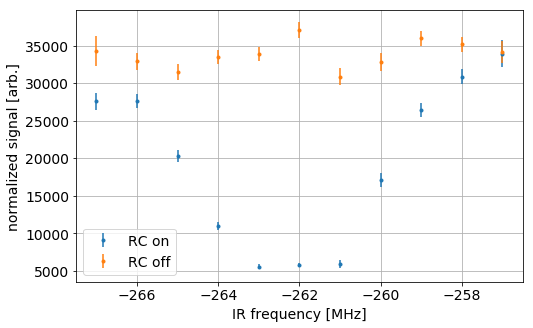

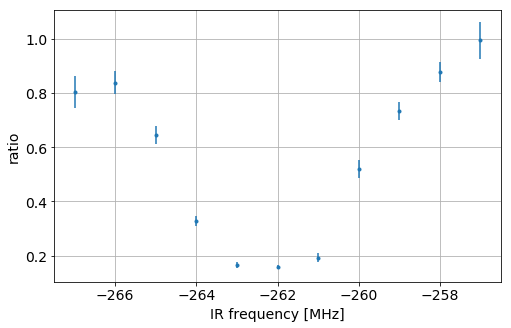

In [761]:
fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, results[0][0], yerr = results[0][1], fmt = '.', label = 'RC on')
ax.errorbar(bin_means, results[1][0], yerr = results[1][1], fmt = '.', label = 'RC off')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('normalized signal [arb.]')
ax.legend(fontsize = 14)

ax.grid(True)
set_fontsize(ax, 14)

ratio, err = ratio_with_error(results[0][0], results[1][0], results[0][1], results[1][1])

fig, ax = plt.subplots(figsize = (8,5))
ax.errorbar(bin_means, ratio, yerr = err, fmt = '.')

ax.set_xlabel('IR frequency [MHz]')
ax.set_ylabel('ratio')

ax.grid(True)

set_fontsize(ax, 14)

## R0 F1 ratio and population with RC laser pol switching (49 mW)

In [658]:
dset_name = dset_names[46]
devices = ()

In [659]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [660]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [661]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 5
fl_cutoff = -5000

In [662]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [663]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [664]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 8.41 +/- 0.16


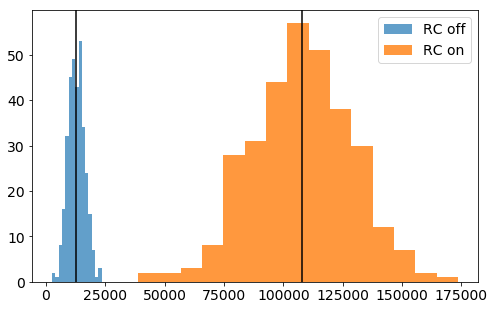

In [665]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 8.94 +/- 0.16


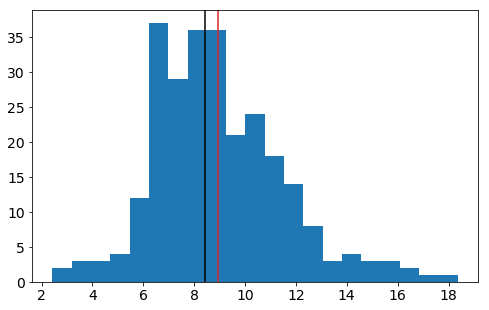

In [666]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F2 ratio and population with RC laser pol switching (49 mW)

In [667]:
dset_name = dset_names[48]
devices = ()

In [668]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [669]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [670]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [671]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [672]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [673]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 3.60 +/- 0.07


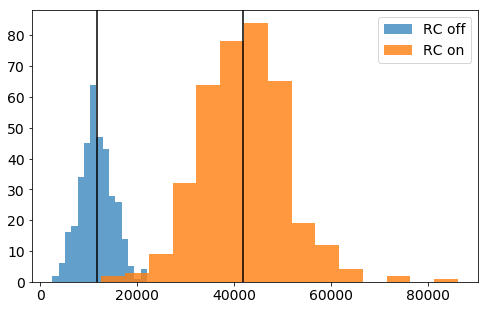

In [674]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 3.89 +/- 0.08


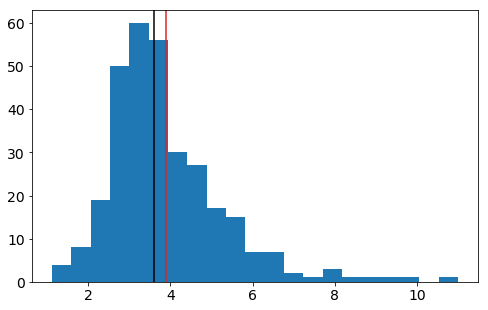

In [675]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F2 ratio and population with RC laser pol switching (53 mW)

In [676]:
dset_name = dset_names[49]
devices = ()

In [677]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [678]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [679]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [680]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [681]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [682]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 3.76 +/- 0.08


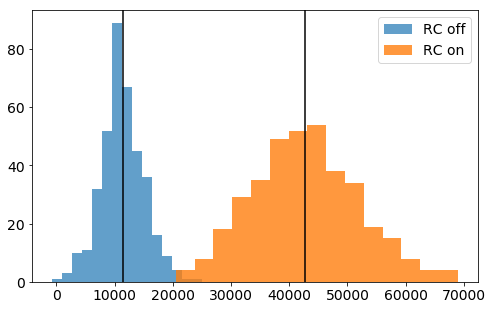

In [683]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 4.17 +/- 0.10


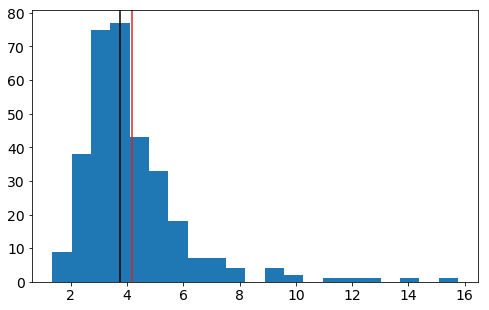

In [684]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F1 ratio and population with RC laser pol switching (53 mW)

In [685]:
dset_name = dset_names[50]
devices = ('SynthHD Pro',)

In [686]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [687]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [688]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [689]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [690]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [691]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 8.10 +/- 0.11


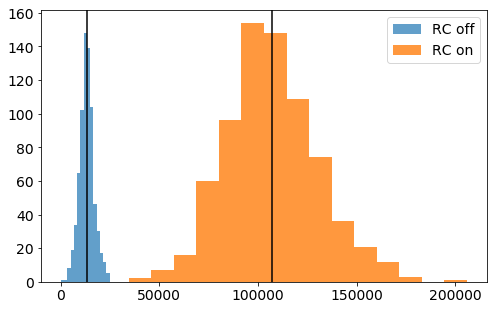

In [692]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 8.54 +/- 0.10


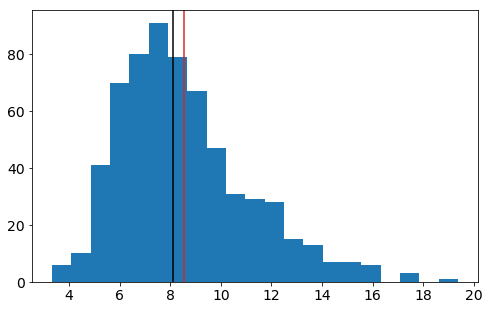

In [693]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")

## R0 F1 ratio and population with RC laser pol switching (53 mW) no microwaves

In [694]:
dset_name = dset_names[51]
devices = ()

In [695]:
slice_flm  = np.s_[-250:]
slice_absm = np.s_[-500:]
slice_fli  = np.s_[100:]
slice_absi = np.s_[10:]

In [696]:
pxie, pxie_time, pxie_attrs, data_devices = load_measurement_data_devices_attrs(hdf_dir / fname, dset_name, devices)

yag_data = np.array([pxie[idx][:,yag_channel] for idx in range(1,len(pxie)+1)])
pmt_data = -np.array([pxie[idx][:,pmt_channel].astype(float) for idx in range(1,len(pxie)+1)])
pd_data = np.array([pxie[idx][:,pd_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdn_data = np.array([pxie[idx][:,pdn_channel].astype(float) for idx in range(1,len(pxie)+1)])
shutter_data = np.array([pxie[idx][:,shutter_channel].astype(float) for idx in range(1,len(pxie)+1)])
pdrc_data = np.array([pxie[idx][:,pdrc_channel].astype(float) for idx in range(1,len(pxie)+1)])

norm_data = -pd_data/pdn_data

In [697]:
yag_cutoff = 250
ptn_cutoff = 19000
abs_cutoff = 4
fl_cutoff = -5000

In [698]:
pmt_data_norm = pmt_data.copy()
norm_data_norm = norm_data.copy()

mask_yag = yag_data.max(axis = 1) < yag_cutoff
mask_pdn = pdn_data.min(axis = 1) < ptn_cutoff
mask_abs = np.trapz(norm_data[:,slice_absi] - norm_data[:,slice_absm].mean(axis = 1)[:, np.newaxis]) < abs_cutoff
mask_fl = np.trapz(pmt_data[:,slice_fli] - pmt_data[:,slice_flm].mean(axis = 1)[:, np.newaxis]) < fl_cutoff

mask = mask_yag | mask_pdn | mask_abs | mask_fl

norm_data_norm[mask] = np.nan
norm_data_norm -= norm_data_norm[:,slice_absm].mean(axis = 1)[:, np.newaxis]

pmt_data_norm[mask] = np.nan
pmt_data_norm -= pmt_data_norm[:,slice_flm].mean(axis = 1)[:, np.newaxis]

In [699]:
fluorescence_integral = np.trapz(pmt_data_norm[:,slice_fli], axis = 1)
absorption_integral = np.trapz(norm_data_norm[:,slice_absi], axis = 1)

mask_sh_open = shutter_data.max(axis = 1) > 10000

nbunch = 10
mask_sh_open = mask_sh_open[:(len(mask_sh_open)//nbunch) * nbunch]
mask_sh_closed = ~mask_sh_open

In [700]:
dat = (fluorescence_integral/absorption_integral)
dat = dat[:len(dat)//nbunch * nbunch]

ratio is 2.76 +/- 0.06


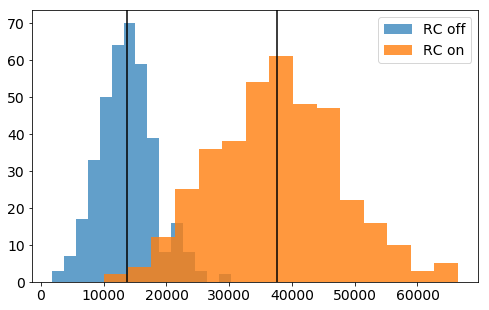

In [701]:
o = np.nanmean(dat[mask_sh_open])
ostd = np.nanstd(dat[mask_sh_open])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_open]))-1)
c = np.nanmean(dat[mask_sh_closed])
cstd = np.nanstd(dat[mask_sh_closed])/np.sqrt(np.sum(~np.isnan(dat[mask_sh_closed]))-1)

fig, ax = plt.subplots(figsize = (8,5))
d = dat[mask_sh_closed]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.7, bins = 15, label = 'RC off')
ax.axvline(c, color = 'k')
d = dat[mask_sh_open]
d = d[~np.isnan(d)]
ax.hist(d, alpha = 0.8, bins = 15, label = 'RC on')
ax.axvline(o, color = 'k')

ax.legend(fontsize = 14)
set_fontsize(ax, 14)

r, rstd = ratio_with_error(o, c, ostd, cstd)
print(f"ratio is {r:.2f} +/- {rstd:.2f}")

ratio is 3.07 +/- 0.08


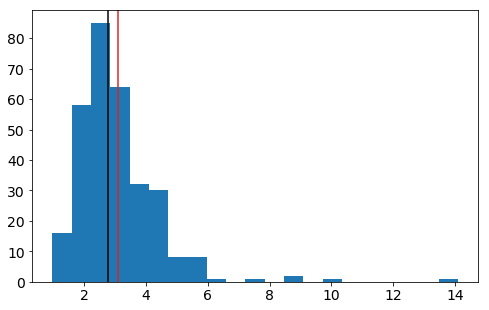

In [702]:
ratio = dat[mask_sh_open]/dat[mask_sh_closed]
ratio = ratio[~np.isnan(ratio)]

fig, ax = plt.subplots(figsize = (8,5))
ax.hist(ratio[ratio < 20], bins = 21);
ax.axvline(r, color = 'k')

rr = np.nanmean(ratio[ratio < 20])
rrstd = np.nanstd(ratio[ratio < 20])/np.sqrt(len(ratio)-1)

ax.axvline(rr, color = 'C3')

set_fontsize(ax, 14)

print(f"ratio is {rr:.2f} +/- {rrstd:.2f}")